# Captcha - v2

**Captcha Classification using DNN.** 

Dataset used : [captcha-version-2-images](https://www.kaggle.com/fournierp/captcha-version-2-images).

Our modified dataset :  [Cleaned Data hosted from Github](https://github.com/Jimut123/MLCP/blob/master/data/captcha_v2.tar.gz)

This notebook is the modified implementation of this kernel in Kaggle [captcha_v2](https://www.kaggle.com/shawon10/captcha-recognition).


In [0]:
# for tensorboard => used to visualize graph, use Runtime-> Interrupt execution to stop this after first run
! python -m tensorboard.main --logdir=/path/to/logs

TensorBoard 1.15.0 at http://6786f317b034:6007/ (Press CTRL+C to quit)


In [1]:
# import libraries
import os
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
import warnings
warnings.filterwarnings('ignore')
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


from keras import layers        # functional 
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import cv2
import string
import numpy as np
from datetime import datetime
from packaging import version
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model  #plotting the model structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline 
import matplotlib.pyplot as plt

# load tensorboard for visualizations
%load_ext tensorboard 


Using TensorFlow backend.


In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [0]:
# 
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# from getpass import getpass
# user = getpass('Enter your username : ')
# password = getpass('Enter your password : ')
# os.environ['GITHUB_AUTH'] = user + ':' + password
# !git clone https://$GITHUB_AUTH@github.com/Jimut123/CAPTCHA.git
# 


Download the dataset in the current folder of Colab. Download using `wget ` command in shell, and rename it using `-O`. This is superior to storing in google drive since, after sometime, Google drive will not be able to perform computation using GPU, but this will be stored in temporary folder and removed later.

In [2]:
!wget "https://github.com/Jimut123/MLCP/blob/master/data/captcha_v2.tar.gz?raw=true" -O captcha_v2.tar.gz

--2020-03-23 05:45:56--  https://github.com/Jimut123/MLCP/blob/master/data/captcha_v2.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Jimut123/MLCP/raw/master/data/captcha_v2.tar.gz [following]
--2020-03-23 05:45:57--  https://github.com/Jimut123/MLCP/raw/master/data/captcha_v2.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Jimut123/MLCP/master/data/captcha_v2.tar.gz [following]
--2020-03-23 05:45:57--  https://raw.githubusercontent.com/Jimut123/MLCP/master/data/captcha_v2.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting

Untar the compressed dataset using `tar` command in shell.

```
../captcha_v2
  | - samples
  | - train
```

In [3]:
!tar -xvf captcha_v2.tar.gz > /dev/null
! echo "Untaring... done..."

Untaring... done...


In [0]:
#!rm -rf captcha_v2
#!cd captcha_v2

!cd captcha_v2


In [5]:
!ls

captcha_v2  captcha_v2.tar.gz  sample_data


In [23]:
# print the first 10 contents of the train directory
import glob
png_files = png_files = glob.glob('captcha_v2/train/*.png') 
print(os.listdir("captcha_v2/train")[:10])
png_files[:10]

['8gmc4.png', 'gn2d3.png', 'fcmem.png', '7dgc2.png', '37d52.png', 'pxdwp.png', '7xcyd.png', '3n3cf.png', 'nn4wx.png', 'e5n66.png']


['captcha_v2/train/8gmc4.png',
 'captcha_v2/train/gn2d3.png',
 'captcha_v2/train/fcmem.png',
 'captcha_v2/train/7dgc2.png',
 'captcha_v2/train/37d52.png',
 'captcha_v2/train/pxdwp.png',
 'captcha_v2/train/7xcyd.png',
 'captcha_v2/train/3n3cf.png',
 'captcha_v2/train/nn4wx.png',
 'captcha_v2/train/e5n66.png']

In [0]:

#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)


In [8]:
print(num_symbols)

36


In [0]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [0]:
def preprocess_data():
    n_samples = len(os.listdir('captcha_v2/samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('captcha_v2/samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('captcha_v2/samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

## Summary of the model

In [11]:
model=create_model();
model.summary();













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 200, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 200, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 25, 100, 16)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 25, 100, 32)  4640     

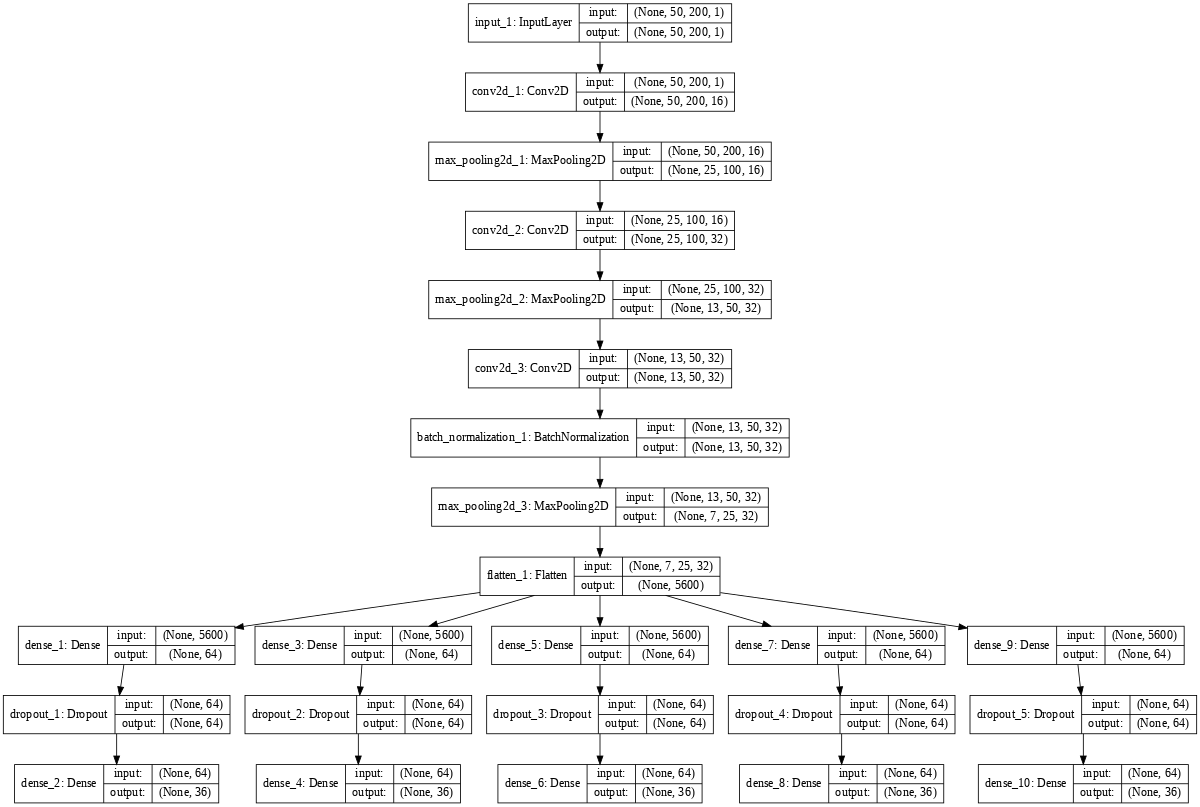

In [12]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

## Train the model

In [13]:
# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2,callbacks=[tensorboard_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 776 samples, validate on 194 samples
Epoch 1/30
776/776 [==============================] - 9s 11ms/step - loss: 17.2341 - dense_2_loss: 3.4182 - dense_4_loss: 3.4629 - dense_6_loss: 3.4105 - dense_8_loss: 3.5147 - dense_10_loss: 3.4278 - dense_2_acc: 0.0593 - dense_4_acc: 0.0477 - dense_6_acc: 0.0541 - dense_8_acc: 0.0503 - dense_10_acc: 0.0503 - val_loss: 16.4352 - val_dense_2_loss: 3.2666 - val_dense_4_loss: 3.2397 - val_dense_6_loss: 3.2488 - val_dense_8_loss: 3.4312 - val_dense_10_loss: 3.2488 - val_dense_2_acc: 0.0670 - val_dense_4_acc: 0.0412 - val_dense_6_acc: 0.0515 - val_dense_8_acc: 0.0258 - val_dense_10_acc: 0.0825
Epoch 2/30
776/776 [==============================] - 1s 844us/step - loss: 16.0842 - dense_2_loss: 3.1747 - dense_4_loss: 3.1765 - dense_6_loss: 3.1738 - dense_8_loss: 3.3263 - dense_10_loss: 3.2330 - dense_2_acc: 0.0644 - dense_4_acc: 0.0722 - dense_6_acc: 0.

## Run tensorboard for Visualization

Check the Graph for pubs.

In [14]:
# https://www.tensorflow.org/tensorboard/graphs
%tensorboard --logdir logs

## Predict the captcha

In [0]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5


In [16]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)

100/100 [==============================] - 0s 683us/step
Test Loss and accuracy: [1.9919496250152589, 0.0040655284957028925, 0.1805691148666665, 0.4867620605044067, 0.7354333972930909, 0.5851195120811462, 1.0, 0.95, 0.86, 0.76, 0.79]


In [17]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict('captcha_v2/train/226md.png'))
print(predict('captcha_v2/samples/f2m8n.png'))
print(predict('captcha_v2/samples/dce8y.png'))
print(predict('captcha_v2/samples/3eny7.png'))
print(predict('captcha_v2/samples/npxb7.png'))


100/100 [==============================] - 0s 267us/step
226md
f2m8n
dce8y
3eny7
npxb7


In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    plt.figure(figsize=(12,7))
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(figsize=(12,7))
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


## Plot the history in different plots

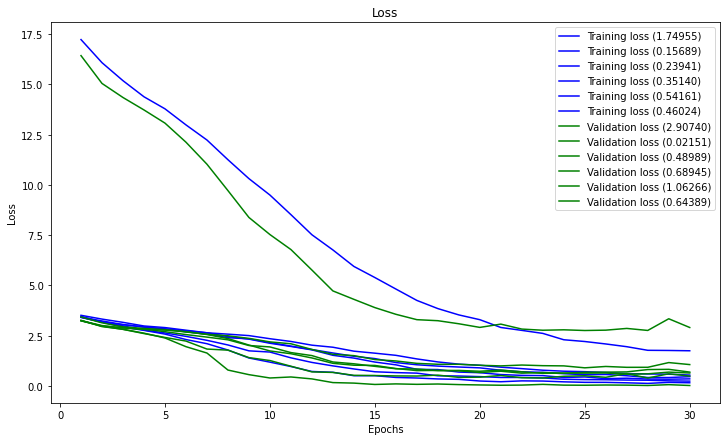

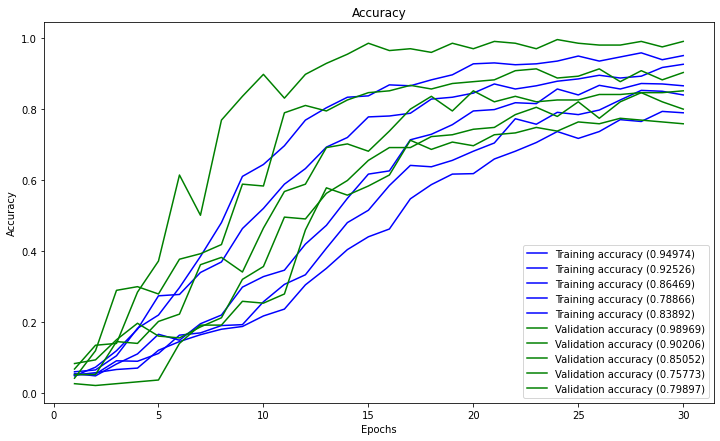

In [19]:

plot_history(hist)

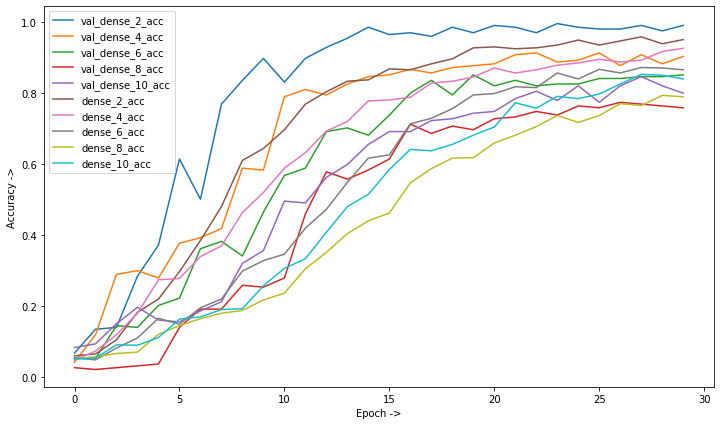

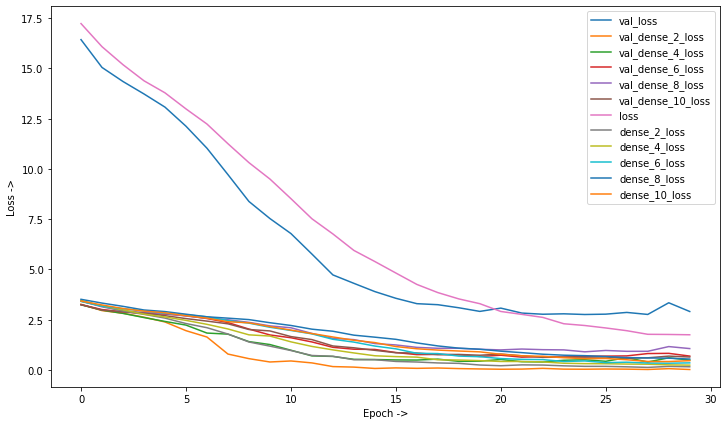

In [20]:
# print(hist.history.keys())
# summarize history for accuracy
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss

# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in hist.history.keys():
  if item.split('_')[-1:] == ['acc']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(hist.history[item])
plt.ylabel('Accuracy ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper left')
plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in hist.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(hist.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()

## Accuracy

Accuracy =  87.85046728971963


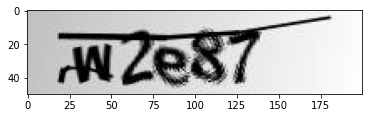

In [21]:
#testing
c=0
total = 0
for i, pic in enumerate(os.listdir('captcha_v2/train/')):
        #Read image as grayscale
        total += 1
        img = cv2.imread(os.path.join('captcha_v2/train/', pic), cv2.IMREAD_GRAYSCALE)
        #print("Predicted Captcha =",predict(os.path.join('captcha_v2/train/',pic)))
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        pr=predict(os.path.join('captcha_v2/train/',pic))
        pic_target = pic[:-4]
        if pr==pic_target:
            c=c+1
            #print(c)
        #print(pic_target)
print("Accuracy = ",(c/total)*100)

## Trying to visualise every layer of the DNN

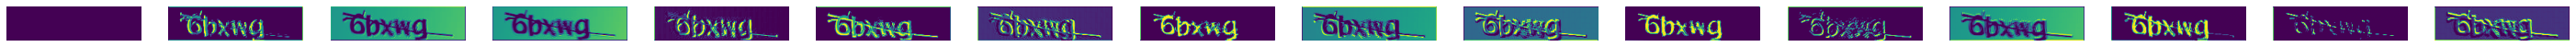

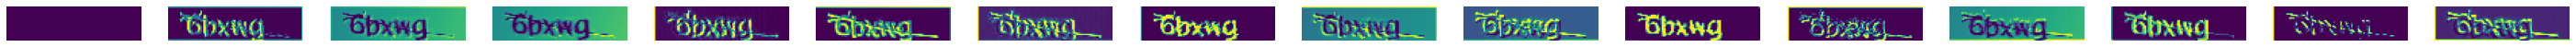

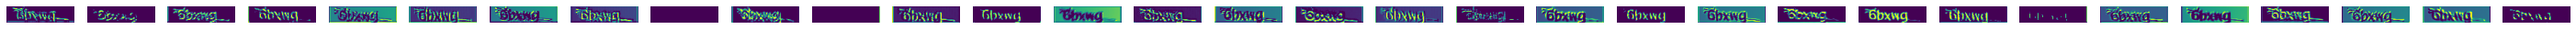

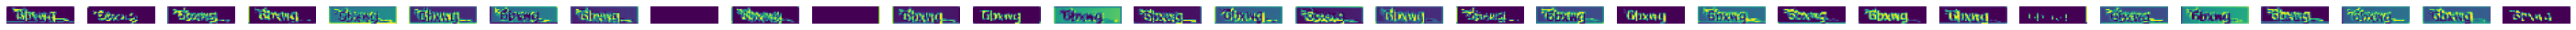

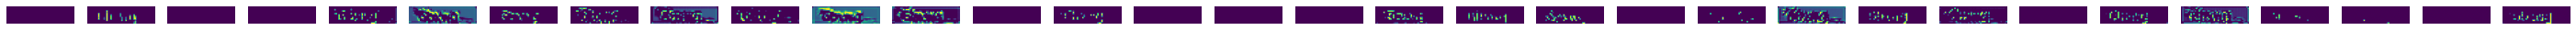

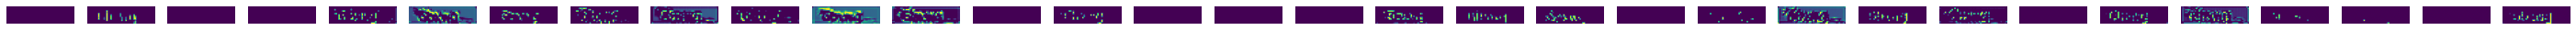

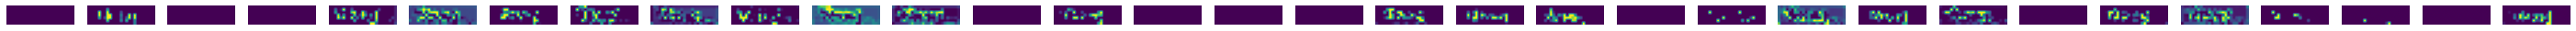

In [22]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
# horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
# human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
# img_path = random.choice(horse_img_files + human_img_files)
img_path = "captcha_v2/train/6bxwg.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#img_res = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA) 
#img = load_img(img_path, target_size=(50, 200))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    size2 = feature_map.shape[2]
    # We will tile our images in this matrix
    plt.figure(figsize=(50, 15))
    #display_grid = np.zeros((size, size * n_features))
    count = 1
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
     
      # We'll tile each filter into this big horizontal grid
      plt.subplot(1, n_features, count)
      plt.imshow(x, cmap='viridis')
      plt.axis("off")
      count += 1
      #display_grid[:, i * size : (i + 1) * size2] = x
    plt.xticks([])
    
    plt.yticks([])
    plt.show()
    # Display the grid
    # scale = 20. / n_features
    # plt.figure(figsize=(scale * n_features, scale))
    # plt.title(layer_name)
    # plt.grid(False)
    # plt.imshow(display_grid, aspect='auto', cmap='viridis')

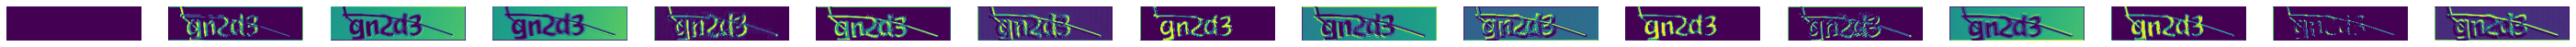

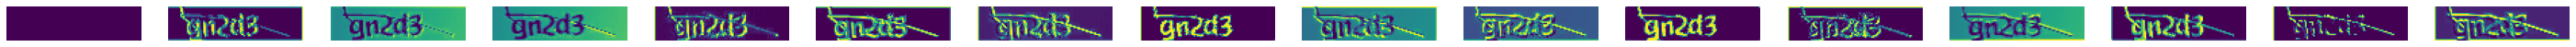

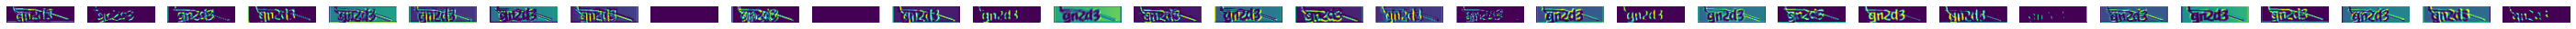

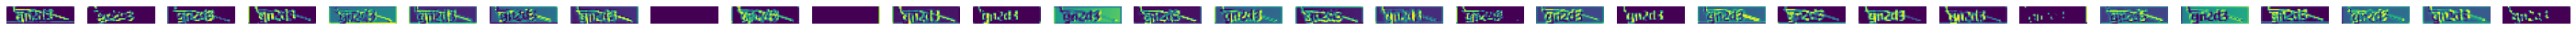

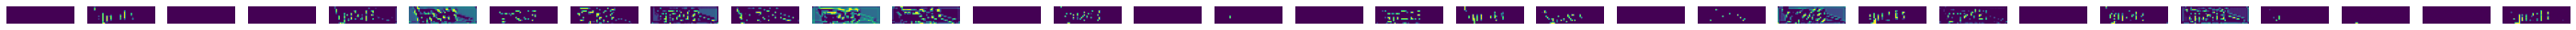

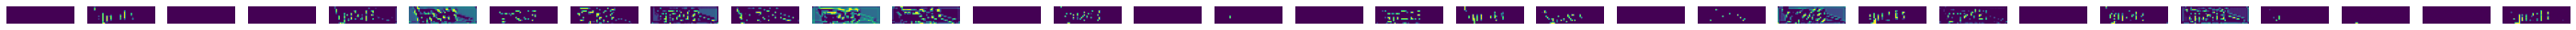

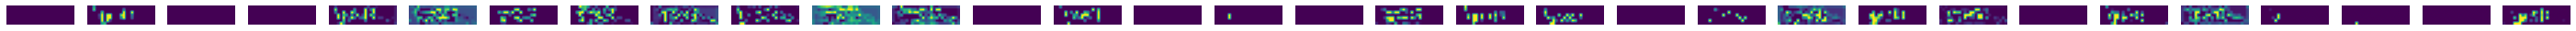

In [24]:
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
# horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
# human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
# img_path = random.choice(horse_img_files + human_img_files)
img_path = png_files[1]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#img_res = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA) 
#img = load_img(img_path, target_size=(50, 200))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    size2 = feature_map.shape[2]
    # We will tile our images in this matrix
    plt.figure(figsize=(50, 15))
    #display_grid = np.zeros((size, size * n_features))
    count = 1
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
     
      # We'll tile each filter into this big horizontal grid
      plt.subplot(1, n_features, count)
      plt.imshow(x, cmap='viridis')
      plt.axis("off")
      count += 1
      #display_grid[:, i * size : (i + 1) * size2] = x
    plt.xticks([])
    
    plt.yticks([])
    plt.show()

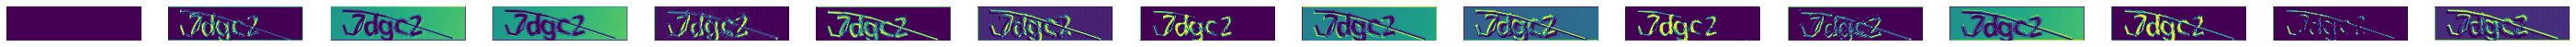

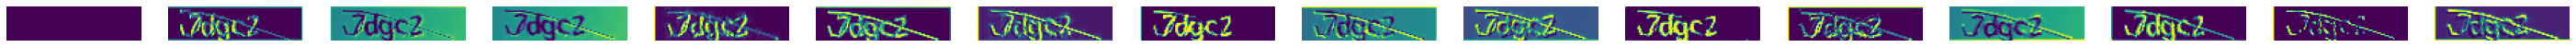

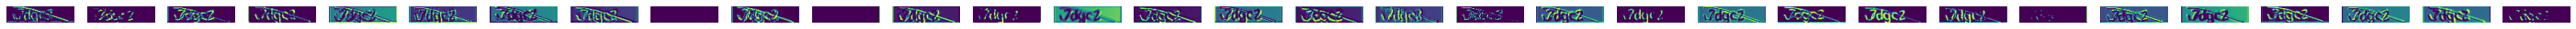

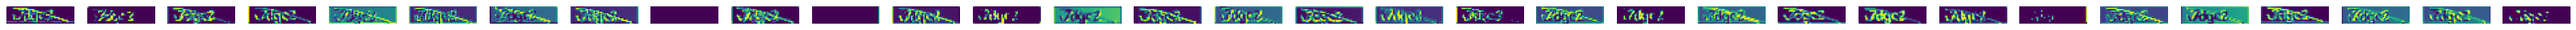

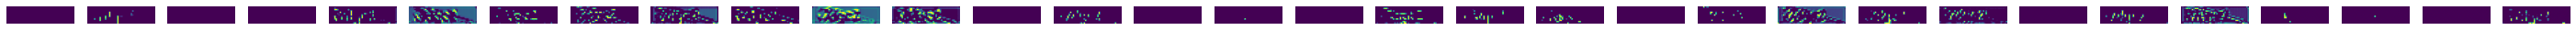

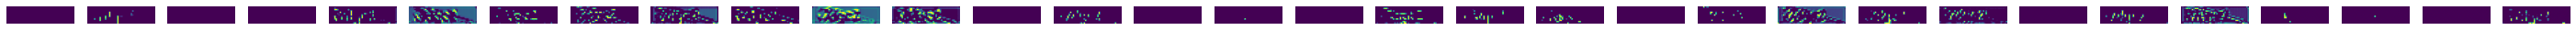

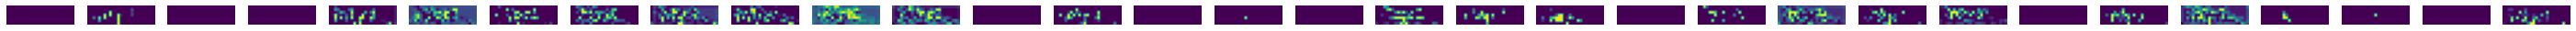

In [25]:
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
# horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
# human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
# img_path = random.choice(horse_img_files + human_img_files)
img_path = png_files[3]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#img_res = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA) 
#img = load_img(img_path, target_size=(50, 200))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    size2 = feature_map.shape[2]
    # We will tile our images in this matrix
    plt.figure(figsize=(50, 15))
    #display_grid = np.zeros((size, size * n_features))
    count = 1
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
     
      # We'll tile each filter into this big horizontal grid
      plt.subplot(1, n_features, count)
      plt.imshow(x, cmap='viridis')
      plt.axis("off")
      count += 1
      #display_grid[:, i * size : (i + 1) * size2] = x
    plt.xticks([])
    
    plt.yticks([])
    plt.show()